In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from google.colab import drive
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import os


In [ ]:
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Datasets/Dataset.zip -d /content

In [3]:
channel = 3
g_dim = 96
d_dim = 16
class_num= 5
epochs = 100
latent_dim=100
batch_size = 100

random.seed(1000)
torch.manual_seed(1000)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),])

data = torchvision.datasets.ImageFolder('/content/Dataset',transform=transform)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

torch.Size([100, 3, 32, 32])


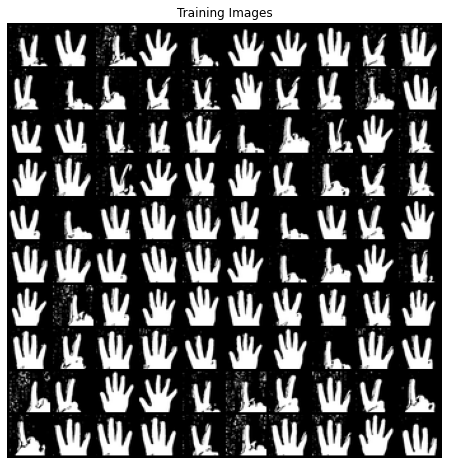

In [5]:
real_batch, _ = next(iter(train_loader))

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device),nrow=10,padding=2, normalize=True).cpu(),(1,2,0)))

print(real_batch.size())

In [6]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.layer1 = nn.Linear(latent_dim+class_num,g_dim*8)
    self.layer2 = nn.Sequential(
      nn.ConvTranspose2d(g_dim*8,g_dim*4,4,stride=2),
      nn.BatchNorm2d(g_dim*4,momentum=0.1,eps=1e-5),)
    self.layer3 = nn.Sequential(
      nn.ConvTranspose2d(g_dim*4,g_dim*2,4,stride=2,padding=1),
      nn.BatchNorm2d(g_dim*2,momentum=0.1,eps=1e-5),)
    self.layer4 = nn.Sequential(
      nn.ConvTranspose2d(g_dim*2,g_dim,4,stride=2,padding=1),
      nn.BatchNorm2d(g_dim,momentum=0.1,eps=1e-5),)
    self.layer5 = nn.ConvTranspose2d(g_dim,channel,4,stride=2,padding=1)
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = F.relu(self.layer1(x)).view(-1,g_dim*8,1,1)
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    x = F.relu(self.layer4(x))
    x = self.layer5(x)
    return self.tanh(x)
     

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.layer1 = nn.Conv2d(channel,d_dim,3,stride=2,padding=1)
    self.layer2 = nn.Sequential(
        nn.Conv2d(d_dim,d_dim*2,3,stride=1,padding=1),
        nn.BatchNorm2d(d_dim*2,momentum=0.1,eps=1e-5),)
    self.layer3 = nn.Sequential(
        nn.Conv2d(d_dim*2,d_dim*4,3,stride=2,padding=1),
        nn.BatchNorm2d(d_dim*4,momentum=0.1,eps=1e-5),)
    self.layer4 = nn.Sequential(
        nn.Conv2d(d_dim*4,d_dim*8,3,stride=1,padding=1),
        nn.BatchNorm2d(d_dim*8,momentum=0.1,eps=1e-5),)
    self.layer5 = nn.Sequential(
        nn.Conv2d(d_dim*8,d_dim*16,3,stride=2,padding=1),
        nn.BatchNorm2d(d_dim*16,momentum=0.1,eps=1e-5),)
    self.layer6 = nn.Sequential(
        nn.Conv2d(d_dim*16,d_dim*32,3,stride=1,padding=1),
        nn.BatchNorm2d(d_dim*32,momentum=0.1,eps=1e-5),)
    self.cls_fc_layer7 = nn.Linear(d_dim*32*4*4,class_num) # cls
    self.real_fc_layer7 = nn.Linear(d_dim*32*4*4,1) # fake/real
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = F.leaky_relu(self.layer1(x),0.2)
    x = F.leaky_relu(self.layer2(x),0.2)
    x = F.leaky_relu(self.layer3(x),0.2)
    x = F.leaky_relu(self.layer4(x),0.2)
    x = F.leaky_relu(self.layer5(x),0.2)
    x = F.leaky_relu(self.layer6(x),0.2)
    x = x.view(-1,d_dim*32*4*4)
    cls = self.cls_fc_layer7(x)
    real = self.real_fc_layer7(x)

    return self.softmax(cls), self.sigmoid(real)

In [7]:
G = Generator().to(device)
D = Discriminator().to(device)

real_cri = nn.BCELoss()
cls_cri = nn.NLLLoss()

G_optimizer = optim.Adam(G.parameters(), lr=9e-4,betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(), lr=4e-4,betas=(0.5,0.999))

fixed_latent = torch.randn(batch_size,latent_dim,device=device)
fixed_labels = torch.zeros(batch_size,class_num,device=device)

for j in range(10):
  for i in range(class_num):
    fixed_labels[i*10+j][i]=1

fixed_noise=torch.cat((fixed_latent,fixed_labels),1)


In [8]:
def compute_cls_acc(m_disc,cls_labels):
  return ((m_disc.argmax(dim=1) == cls_labels)*1.0).sum()/100

Gen_los = []
Disc_los = []
real_dis=[]
fake_dis=[]
real_cls=[]
fake_cls=[]

for ep  in range(epochs):
  for i, (data, cls_labels) in enumerate(train_loader):
    data = data.to(device)
    cls_labels = cls_labels.to(device)

    b_size=data.shape[0]

    class_target=torch.zeros(b_size,class_num,device=device)
    class_target[torch.arange(b_size), cls_labels] = 1.0

    real_labels = torch.ones(b_size,1).to(device)
    fake_labels = torch.zeros(b_size,1).to(device)

    # with real
    # Train Discriminator
    D.zero_grad()
    _ , real_score = m_disc, b_disc = D(data)
    bce_real_loss = real_cri(b_disc,real_labels)
    cls_real_loss = cls_cri(m_disc,cls_labels)

    real_cls_acc=compute_cls_acc(m_disc,cls_labels)

    #with fake
    noise0 = torch.randn(b_size,latent_dim).to(device)
    c = class_target
    noise = torch.cat((noise0,c),dim=1)

    fake = G(noise)
    _, fake_score = m_disc, b_disc = D(fake.detach())
    bce_fake_loss = real_cri(b_disc,fake_labels)
    cls_fake_loss = cls_cri(m_disc,cls_labels)

    fake_cls_acc=compute_cls_acc(m_disc,cls_labels)


    D_Ls = bce_real_loss + bce_fake_loss
    D_Lc = 1.8*cls_real_loss + 0.2*cls_fake_loss 
    loss_D = D_Ls + D_Lc

    loss_D.backward()

    D_optimizer.step()

    #Train Generator
    G.zero_grad()
    m_disc, b_disc = D(fake)
    G_Ls = real_cri(b_disc,real_labels)
    G_Lc = cls_cri(m_disc,cls_labels)
    loss_G = G_Ls + G_Lc
    loss_G.backward()
    G_optimizer.step()
    
  print(f'epoch {ep}: d_loss: {loss_D.item()} , g_loss: {loss_G.item()}')
  Gen_los.append(loss_G.item())
  Disc_los.append(loss_D.item())
  real_dis.append(real_score.mean().item())
  fake_dis.append(fake_score.mean().item())
  real_cls.append(real_cls_acc.item())
  fake_cls.append(fake_cls_acc.item())
     

epoch 0: d_loss: -1.314489722251892 , g_loss: 12.921239852905273
epoch 1: d_loss: -1.784238576889038 , g_loss: 12.347855567932129
epoch 2: d_loss: -0.9490946531295776 , g_loss: 19.173736572265625
epoch 3: d_loss: -1.8202584981918335 , g_loss: 7.049768924713135
epoch 4: d_loss: -1.7118937969207764 , g_loss: 5.098384857177734
epoch 5: d_loss: -1.7951470613479614 , g_loss: 15.169167518615723
epoch 6: d_loss: -1.8453245162963867 , g_loss: 19.33736801147461
epoch 7: d_loss: -1.7285223007202148 , g_loss: 6.714127063751221
epoch 8: d_loss: -1.0155467987060547 , g_loss: 18.482627868652344
epoch 9: d_loss: -1.629417896270752 , g_loss: 5.740833282470703
epoch 10: d_loss: -0.8731269836425781 , g_loss: 12.507447242736816
epoch 11: d_loss: -1.6250807046890259 , g_loss: 12.046463012695312
epoch 12: d_loss: 0.3555290699005127 , g_loss: 11.203740119934082
epoch 13: d_loss: -0.8898240327835083 , g_loss: 6.818603992462158
epoch 14: d_loss: -1.6277339458465576 , g_loss: 3.089406967163086
epoch 15: d_loss

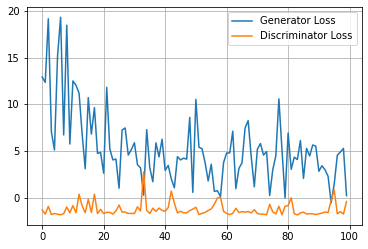

In [9]:
plt.plot(Gen_los, label='Generator Loss')
plt.plot(Disc_los, label='Discriminator Loss')
plt.legend()
plt.grid()
plt.show()

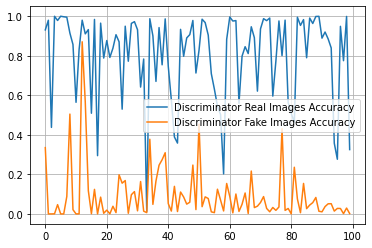

In [10]:
plt.plot(real_dis, label='Discriminator Real Images Accuracy')
plt.plot(fake_dis, label='Discriminator Fake Images Accuracy')
plt.legend()
plt.grid()
plt.show()

In [11]:
noise0 = torch.randn(b_size,latent_dim).to(device)
c = class_target
noise = torch.cat((noise0,c),dim=1)

In [12]:
from torchvision.utils import make_grid
def show_tensor_images(image_tensor, num_images=25, size=(1, 32, 32)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

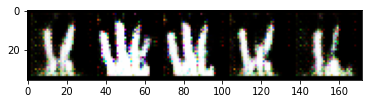

In [13]:
show_tensor_images(G(noise),5)